In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({'font.size': 50})

In [2]:
sns.set()

In [3]:
#pd.read_csv('Scoring.csv')

In [4]:
# df_skaters = pd.DataFrame()
# df_goalies = pd.DataFrame()

# for year in range(2016, 2023):
#     #print(year)
#     try:
#         time.sleep(120)
#         if year == 2005:
#             pass
#         else:
#             temp = pd.read_html(f'https://www.hockey-reference.com/leagues/NHL_{year}_skaters.html')[0]
#             temp['Year'] = year

#             temp2 = pd.read_html(f'https://www.hockey-reference.com/leagues/NHL_{year}_goalies.html')[0]
#             temp2['Year'] = year

#             df_skaters = pd.concat([df_skaters, temp], axis=0)
#             df_goalies = pd.concat([df_goalies, temp2], axis=0)
#             print(year)
#     except:
#         print("no go " + str(year))
        

In [5]:
#df_skaters.columns = df_skaters.columns.droplevel()
#df_goalies.columns = df_goalies.columns.droplevel()


In [6]:
#df_skaters.to_csv('nhl_data_full_2016_2022.csv')

In [7]:
# df_skaters.columns = df_skaters.columns.droplevel()
# df_goalies.columns = df_goalies.columns.droplevel()


# df_skaters.columns = ['Rk', 'Player', 'Age', 'Tm', 'Pos', 'GP', 'G', 'A', 'PTS', '+/-', 'PIM',
#        'PS', 'EV', 'PP', 'SH', 'GW', 'EV', 'PP', 'SH', 'S', 'S%', 'TOI',
#        'ATOI', 'BLK', 'HIT', 'FOW', 'FOL', 'FO%', 'Year']


# df_skaters = df_skaters[['Rk', 'Player', 'Age', 'Tm', 'Pos', 'GP', 'G', 'A', 'PTS', '+/-', 'PIM',
#         'PS', 'EV', 'PP', 'SH', 'GW', 'EV', 'PP', 'SH', 'S', 'S%', 'TOI',
#         'ATOI', 'Year']]
# # df_goalies.columns = ['Rk', 'Player', 'Age', 'Tm', 'GP', 'GS', 'W', 'L', 'T/O', 'GA', 'SA',
# #        'SV', 'SV%', 'GAA', 'SO', 'GPS', 'MIN', 'QS', 'QS%', 'RBS', 'GA%-',
# #        'GSAA', 'G', 'A', 'PTS', 'PIM', 'Year']

# # df_skaters['PIM'] = df_skaters['PIM'].fillna(0)
# # df_skaters['S%'] = df_skaters['S%'].fillna(0)

# df_skaters = df_skaters[df_skaters.Age != 'Age']
# df_goalies = df_goalies[df_goalies.Age != 'Age']

# df_skaters = pd.concat([df_skaters[['Rk', 'Player', 'Tm', 'Pos']], df_skaters[['Age','GP', 'G', 'A', 'PTS', '+/-', 'PIM',
#        'PS', 'GW', 'S', 'S%','TOI', 'Year']].apply(pd.to_numeric)], axis=1)

# df_goalies = pd.concat([df_goalies[['Rk', 'Player', 'Tm']], df_goalies[['Age','GP', 'W', 'L', 'T/O', 'GA', 'SA',
#        'SV', 'SV%', 'GAA', 'SO', 'GPS', 'MIN', 'PIM','Year']].apply(pd.to_numeric)], axis=1)

In [8]:
df1 = pd.read_csv('nhl_data_full_2016_2022.csv')
df2 = pd.read_csv('nhl_data_full_1965_2015.csv')
df3 = pd.read_csv('nhl_data_full_1920_1964.csv')

data = pd.concat([df1, df2, df3], axis=0)


In [9]:
data_nodups = data.groupby(["Player","Year"], sort=False, as_index=False)['PTS'].agg({"PTS":"sum"})

data_clean = data.drop("PTS", axis=1).merge(data_nodups, on = ["Player","Year"], how= 'inner').drop_duplicates(subset=['Player','Year'], keep = 'first')

In [10]:
data_clean2 = data_clean.drop_duplicates(subset=['Player','Age'])

In [11]:
data_clean2['Player_season'] = data_clean2.groupby('Player').transform('cumcount')
data_clean2['career_len'] = data_clean2.groupby('Player')['Player_season'].transform('max')
data_clean2['age_max'] = data_clean2.groupby('Player')['Age'].transform('max')
data_clean2['age_min'] = data_clean2.groupby('Player')['Age'].transform('min')
data_clean2['PPG'] = data_clean2['PTS']/data_clean2['GP']

data_clean2['PPG_past'] = data_clean2.groupby('Player')['PPG'].shift(1)
data_clean2['PPG_delta'] = data_clean2['PPG'] - data_clean2['PPG_past']

data_clean2['PPG_career'] = data_clean2.groupby(['Player'])['PTS'].transform('sum')/data_clean2.groupby(['Player'])['GP'].transform('sum')
data_clean2['PS_career'] = data_clean2.groupby(['Player'])['PS'].transform('sum')
data_clean2['GP_career'] = data_clean2.groupby(['Player'])['GP'].transform('sum')

data_clean2.loc[data_clean2.Pos.isin(['LW','C', 'RW', 'F', 'W']), 'Pos_group'] = 'FWD'
data_clean2.loc[data_clean2.Pos.isin(['D']), 'Pos_group'] = 'D'

In [12]:
### i think this is right...####

active_players = list(data_clean2[data_clean2.Year == 2022]["Player"].unique())
data_clean2 = data_clean2[~data_clean2.Player.isin(active_players)]

In [13]:
data_clean2.groupby(['Pos_group'])['Age'].describe().reset_index()

,Pos_group,count,mean,std,min,25%,50%,75%,max
0,D,12766.0,26.542613,4.434776,17.0,23.0,26.0,29.0,48.0
1,FWD,24970.0,26.172367,4.323997,17.0,23.0,26.0,29.0,51.0


In [14]:
age_samples = data_clean2[data_clean2.Pos_group == 'D'].groupby('Age').size().reset_index()
age_samples.columns = ['Age', 'num_samples']

(17.0, 40.0)

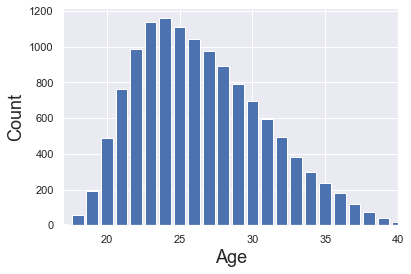

In [15]:
plt.bar(age_samples['Age'], age_samples['num_samples'])
plt.xlabel('Age',fontsize=18)
plt.ylabel('Count',fontsize=18)
plt.xlim(17,40)

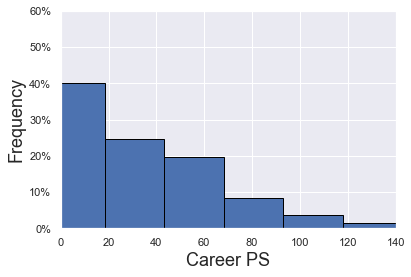

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(data_clean2[data_clean2.Pos_group == 'D']['PS_career'], edgecolor='black', weights=np.ones_like(data_clean2[data_clean2.Pos_group == 'D']['PS_career'])*100 / len(data_clean2[data_clean2.Pos_group == 'D']['PS_career']))
ax.yaxis.set_major_formatter(PercentFormatter())
ax.set_xlim(0,140)
ax.set_ylim(0,60)
ax.set_xlabel('Career PS',fontsize=18)
ax.set_ylabel('Frequency',fontsize=18);

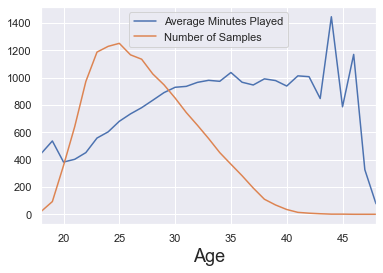

In [17]:
data_clean2.groupby(['Age'])['TOI'].mean().plot(label = 'Average Minutes Played')
data_clean2.groupby(['Age'])['TOI'].count().plot(label = 'Number of Samples')
plt.xlim(18,48)
plt.xlabel('Age',fontsize=18)
plt.ylabel('',fontsize=18)
plt.legend();

In [18]:
#list(data_clean2.Player.unique())

In [19]:
f1 = data_clean2[data_clean2.Player == 'Henrik Zetterberg']
f2 = data_clean2[data_clean2.Player == 'Andrew Shaw']
f3 = data_clean2[data_clean2.Player == 'Ty Rattie']

In [20]:
d1 = data_clean2[data_clean2.Player == 'Mark Pysyk']
d2 = data_clean2[data_clean2.Player == 'Aaron Ness']
d3 = data_clean2[data_clean2.Player == 'Dainius Zubrus']

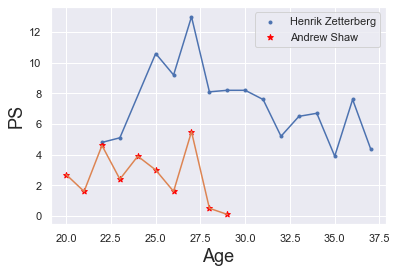

In [21]:
f1 = f1.sort_values('Age')
f2 = f2.sort_values('Age')

plt.scatter(f1['Age'], f1['PS'], label = 'Henrik Zetterberg', marker = '.')
plt.plot(f1['Age'], f1['PS'])
plt.scatter(f2['Age'], f2['PS'], color = 'red', label = 'Andrew Shaw', marker='*')
plt.plot(f2['Age'], f2['PS'])
#plt.scatter(f3['Age'], f3['PS'], color = 'green', label = 'Ty Rattie')
plt.xlabel('Age',fontsize=18)
plt.ylabel('PS',fontsize=18)
plt.legend();

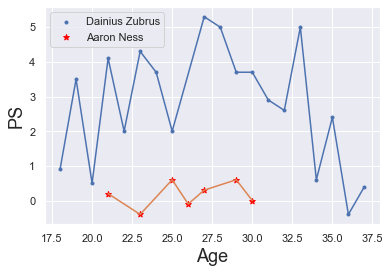

In [22]:
d3 = d3.sort_values('Age')
d2 = d2.sort_values('Age')

plt.scatter(d3['Age'], d3['PS'], label = 'Dainius Zubrus', marker = '.')
plt.plot(d3['Age'], d3['PS'])
plt.scatter(d2['Age'], d2['PS'], color = 'red', label = 'Aaron Ness', marker='*')
plt.plot(d2['Age'], d2['PS'])
#plt.scatter(f3['Age'], f3['PS'], color = 'green', label = 'Ty Rattie')
plt.xlabel('Age',fontsize=18)
plt.ylabel('PS',fontsize=18)
plt.legend();

In [23]:
data_clean2['PS_career_mean'] = data_clean2.groupby('Player')['PS'].transform('mean')

In [24]:
data_clean2['PS_normalized'] = data_clean2['PS'] - data_clean2['PS_career_mean']

<AxesSubplot:>

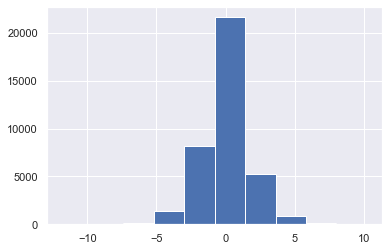

In [25]:
data_clean2['PS_normalized'].hist()

<AxesSubplot:>

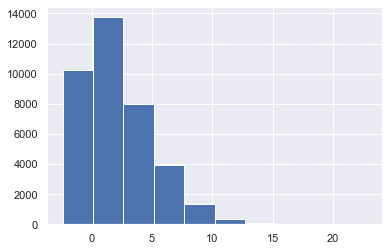

In [26]:
data_clean2['PS'].hist()

In [27]:
data_clean2_fwd = data_clean2[data_clean2.Pos_group == 'FWD']
data_clean2_D = data_clean2[data_clean2.Pos_group == 'D']

data_clean2_fwd['Player'] = data_clean2_fwd['Player'].str.replace('*', '')
data_clean2_D['Player'] = data_clean2_D['Player'].str.replace('*', '')

In [28]:
data_clean2_fwd_trim = data_clean2_fwd[(data_clean2_fwd.GP > 30)&(data_clean2_fwd.Age > 20)&(data_clean2_fwd.Age < 35)]

In [29]:
data_clean2_fwd_trim = data_clean2_fwd_trim.drop_duplicates(subset=['Player','Age'])

In [30]:
data_clean2_fwd_trim = data_clean2_fwd_trim.sort_values(['Player','Age'])

In [31]:
data_clean2_fwd_trim['career'] = data_clean2_fwd_trim.groupby('Player')['Player_season'].transform('count')

In [32]:
data_clean2_fwd_trim = data_clean2_fwd_trim[data_clean2_fwd_trim['career'] > 7]

In [33]:
#data_clean2_D_trim.to_csv('nhl_data_trim2.csv')

In [34]:
len(data_clean2_fwd_trim)

9814

In [35]:
len(list(data_clean2_fwd_trim['Player'].unique()))

918

In [36]:
train_players = list(data_clean2_fwd_trim['Player'].unique())[0:750]
test_players = list(data_clean2_fwd_trim['Player'].unique())[750:]

In [37]:
len(test_players)

168

In [38]:
data_clean2_fwd_trim_train = data_clean2_fwd_trim[data_clean2_fwd_trim.Player.isin(train_players)]
data_clean2_fwd_trim_test = data_clean2_fwd_trim[data_clean2_fwd_trim.Player.isin(test_players)]

In [ ]:
fwd_list = list(data_clean2_fwd_trim.Player.unique())
#D_list = list(data_clean2_D_trim.Player.unique())

max_age_global = 37

player_list = fwd_list
df_skaters = data_clean2_fwd_trim

#def get_padded_df(df_skaters, player_list):
target_array = []
age_array = []
delta_array = []

for i in player_list:
    delta = []
#     try:
    #try:
    #ovr_list = np.linspace(18, 43, 43-18+1)
    a = df_skaters[df_skaters.Player == i]['Age'].values
    b = df_skaters[df_skaters.Player == i]['PS_normalized'].values

    min_age = min(df_skaters[df_skaters.Player == i]['Age'])
    max_age = max(df_skaters[df_skaters.Player == i]['Age'])


    min_PPG = df_skaters[(df_skaters.Player == i)&(df_skaters.Age == min_age)]['PS_normalized'].values[0]
    max_PPG = df_skaters[(df_skaters.Player == i)&(df_skaters.Age == max_age)]['PS_normalized'].values[0]


    ideal_list = np.linspace(20, max_age_global, max_age_global-22+1) 
    #print(a,ideal_list)
    set1 = set(ideal_list)
    set2 = set(a)
    a = list(a)
    b = list(b)
    missing = list(sorted(set1 - set2))

    for k in range(len(b)):
        delta.append(0)

    #if len(missing) > 0:
#         for j in missing:
#             if j < min_age:
#                 target_array.append(min_PPG)
#             elif j > max_age:
#                 target_array.append(max_PPG)
#             else:
#                 pass
        #print(i)
        #print(missing, max_age, min_age)

    #break
#         #print(missing, a)
#         for j in missing:                
#             index = list(ideal_list).index(j)
#             b.insert(index, np.mean(b))
#     #print(a)       
    forward_pad = min_age - 20
    back_pad = max_age_global - max_age

    #print(forward_pad, back_pad, min_PPG, max_PPG)

#     #print(min_age,max_age,forward_pad,back_pad, len(a))
    b = np.pad(b, (forward_pad, back_pad), 'linear_ramp', end_values=(min_PPG, max_PPG))
    a = np.pad(a, (forward_pad, back_pad), 'linear_ramp', end_values = (20,max_age_global))
    delta = np.pad(delta, (forward_pad, back_pad), 'constant', constant_values=(1, 1))

    target_array.append(b)
    age_array.append(a)
    delta_array.append(delta)
#     except:
#         print(i)

In [ ]:
padded_df = pd.DataFrame()

for i,j,k,l in zip(target_array, player_list, age_array, delta_array):
    temp = pd.DataFrame({'Player': [j]*len(i),
                         'Age': k,
                         'PPG': i,
                         'delta': l})
    
    padded_df = pd.concat([padded_df,temp],axis=0)


In [ ]:
len(padded_df.Player.unique())

In [ ]:
#len(data_clean2_d_trim_test.Player.unique())

In [ ]:
#padded_df = padded_df.fillna(0.307692)

In [ ]:
#padded_df = padded_df.drop_duplicates(['Player','Age'])

In [ ]:
padded_df.to_csv('imfunpca_cluster_D.csv')
#padded_df.to_csv('imfunpca_nhl_32_fwd.csv')
#padded_df.to_csv('imfunpca_d_test.csv')

In [ ]:
data_clean2_fwd_trim.to_csv('cluster_D.csv')

In [ ]:
#data_clean2_d_trim_train

In [ ]:
################### delta method ##############################################################################

In [39]:
data_clean2_fwd_trim_train['PS_shift'] = data_clean2_fwd_trim_train.groupby('Player')['PS'].shift()

In [40]:
data_clean2_fwd_trim_train['GP_shift'] = data_clean2_fwd_trim_train.groupby('Player')['GP'].shift()

In [41]:
data_clean2_fwd_trim_train1 = data_clean2_fwd_trim_train.dropna(subset = 'PS_shift')

In [42]:
data_clean2_d_trim_train1 = data_clean2_fwd_trim_train1[['Player', 'Tm', 'Pos', 'Age', 'GP', 'PS','Year', 'PTS', 'Player_season',
       'career_len', 'age_max', 'age_min','PS_career', 'Pos_group', 'PS_career_mean',
       'PS_normalized', 'career', 'PS_shift', 'GP_shift']]

In [43]:
data_clean2_fwd_trim_train1['PS_delta'] = data_clean2_fwd_trim_train1['PS'] - data_clean2_fwd_trim_train1['PS_shift']

In [44]:
delta_df = data_clean2_fwd_trim_train1.groupby('Age')['PS_delta'].mean().reset_index()
delta_df.columns = ['Age', 'delta']

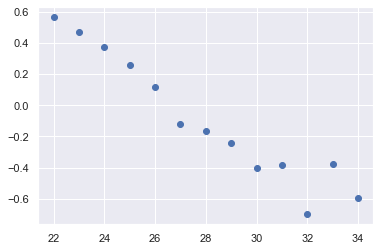

In [45]:
plt.scatter(delta_df['Age'],delta_df['delta'])

In [46]:
data_clean2_fwd_trim_test1 = data_clean2_fwd_trim_train.merge(delta_df, on = 'Age')


In [47]:
data_clean2_fwd_trim_test1 = data_clean2_fwd_trim_test1.sort_values(['Player','Age'])

In [48]:
data_clean2_fwd_trim_test1['proj'] = data_clean2_fwd_trim_test1['PS'] + data_clean2_fwd_trim_test1['PS']*data_clean2_fwd_trim_test1['delta']


In [49]:
data_clean2_fwd_trim_test1['PS_shift_future'] = data_clean2_fwd_trim_test1.groupby('Player')['PS'].shift(-1)

In [50]:
data_clean2_fwd_trim_test1['Error'] = np.abs(data_clean2_fwd_trim_test1['proj'] - data_clean2_fwd_trim_test1['PS_shift_future'])



In [52]:
data_clean2_fwd_trim_test1 = data_clean2_fwd_trim_test1[['Player', 'Tm', 'Pos', 'Age', 'GP', 'Year', 'Player_season',
       'career_len', 'age_max', 'age_min', 'career', 'delta', 'proj','PS', 'PS_shift_future', 'Error']].sort_values(['Player','Age'])

In [53]:
data_clean2_fwd_trim_test1 = data_clean2_fwd_trim_test1.dropna()

In [55]:
data_clean2_fwd_trim_test1['Error'].sum()/len(data_clean2_fwd_trim_test1.Player.unique())

18.390613909847477

In [ ]:
data_clean2_fwd_trim_test1.loc[(data_clean2_fwd_trim_test1.Age <= 26)&(data_clean2_fwd_trim_test1.Age >= 22), 'AgeBin'] = '22-26'
data_clean2_fwd_trim_test1.loc[(data_clean2_fwd_trim_test1.Age <= 30)&(data_clean2_fwd_trim_test1.Age > 26), 'AgeBin'] = '26-30'
data_clean2_fwd_trim_test1.loc[(data_clean2_fwd_trim_test1.Age <= 36)&(data_clean2_fwd_trim_test1.Age > 30), 'AgeBin'] = '30-36'

In [ ]:
data_clean2_fwd_trim_test1.groupby(['AgeBin'])['Error'].mean().plot.bar()
plt.title('Error for the Delta Method (FWD)')
plt.ylabel('MAE')

In [ ]:
##################################################################################################################

In [ ]:
######## train test split for prediction ############

In [56]:
cluster = pd.read_csv('cluster_data_fwd_pace.csv')

In [58]:
#cluster

In [59]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit(cluster[['PC1', 'PC2']])
cluster['labels'] = kmeans.labels_

In [60]:
cluster.groupby('labels')['PC1'].mean()

labels
0    3.992322
1   -0.878546
2   -0.755391
Name: PC1, dtype: float64

In [61]:
cluster.groupby('labels')['PC2'].mean()

labels
0   -0.054385
1   -1.130624
2    3.221485
Name: PC2, dtype: float64

In [70]:
cluster.Player = cluster.Player.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')


In [62]:
data_w_cluster = data_clean2_fwd_trim.merge(cluster, on = 'Player')

In [63]:
data_w_cluster_delta = data_clean2_fwd_trim_test1[['Player','Age','Error']].merge(data_w_cluster, on = ['Player','Age'])

In [64]:
data_w_cluster_delta['tot_err'] = data_w_cluster_delta.groupby(['Player'])['Error'].transform('sum')

In [ ]:
data_w_cluster_delta.loc[(data_w_cluster_delta.Age <= 26)&(data_w_cluster_delta.Age >= 22), 'AgeBin'] = '22-26'
data_w_cluster_delta.loc[(data_w_cluster_delta.Age <= 30)&(data_w_cluster_delta.Age > 26), 'AgeBin'] = '26-30'
data_w_cluster_delta.loc[(data_w_cluster_delta.Age <= 36)&(data_w_cluster_delta.Age > 30), 'AgeBin'] = '30-34'

In [ ]:
data_w_cluster_delta['labels'] = data_w_cluster['labels'] + 1

In [ ]:
#data_w_cluster['labels'].unique()

In [ ]:
data_w_cluster_delta.columns

In [ ]:
data_w_cluster_delta[['Player', 'Age', 'Error']]

In [ ]:
data_w_cluster_delta.groupby('AgeBin')['tot_err'].mean()

In [ ]:
data_w_cluster_delta.groupby('Age')['tot_err'].mean().plot.bar()
plt.title('Error of Delta Method by Age (FWD)')
#plt.xticks([1,2,3],labels = [1,2,3])
plt.xlabel('Age')
plt.ylabel('Error');

In [ ]:
plot_df = data_w_cluster_delta.groupby('PS_career')['tot_err'].mean().reset_index()

In [ ]:
plt.scatter(plot_df['PS_career'], plot_df['tot_err'])
plt.title('Error of Delta Method by Age (FWD)')
#plt.xticks([1,2,3],labels = [1,2,3])
plt.xlabel('Age')
plt.ylabel('Error');

In [ ]:
data_w_cluster_delta.groupby('PS_career')['tot_err'].mean()

In [ ]:
data_w_cluster.groupby('labels')['PS_career'].mean()

In [ ]:
data_w_cluster.groupby('labels')['age_max'].mean()

In [ ]:
data_w_cluster.groupby('labels')['age_min'].mean()

In [ ]:
data_w_cluster.groupby('labels')['PC1'].mean()

In [ ]:
data_w_cluster.groupby('labels')['PC2'].mean()

In [ ]:
cluster['labels'] = cluster['labels'] + 1

In [ ]:
######################################################

In [ ]:
########## Clustering ################################

In [ ]:


ax = sns.scatterplot(data=cluster, x="PC1", y="PC2", hue="labels", style="labels")
#ax.legend(title='Class', loc='upper left', labels=[1,2,3])

In [ ]:
#### do something about 2005 lockout?

# target_array = {}

# player_list = fwd_list
# df_skaters = data_clean2_fwd_trim

# for i in player_list:
#     #try:
#     ovr_list = np.linspace(18, 43, 43-18+1)
#     #a = df_skaters[df_skaters.Player == i]['Age'].values
#     b = df_skaters[df_skaters.Player == i]['PPG'].values

#     min_age = min(df_skaters[df_skaters.Player == i]['Age'])
#     max_age = max(df_skaters[df_skaters.Player == i]['Age'])
#     career_len = df_skaters[df_skaters.Player == i]['career_len'].values[0] 
    
#     a = np.array(list(df_skaters[df_skaters.Player == i]['Age'].values))
    
#     ideal_list = np.linspace(18, 37, 36-19+1) 
#     #print(a,ideal_list)
#     set1 = set(ideal_list)
#     set2 = set(a)
#     a = list(a)
#     b = list(b)
#     missing = list(sorted(set1 - set2))

#     #print(missing)

#     delta = []

#     for j in ideal_list:
#         if (j in missing) & (j < min_age):
#             delta.append(1)
#         elif (j in missing) & (j > max_age):
#             delta.append(2)
#         else:
#             delta.append(0)
        
#     target_array[i] = delta

# player_index = {}

# for i in range(len(player_list)):
#     player_index[i] = player_list[i]

# player_index_df = pd.DataFrame(player_index, index = [0]).T.reset_index()
# player_index_df.columns = ['playerId', 'Player']

# df_skaters_pad_ages = pd.DataFrame(np.stack(age_array)).stack().reset_index()
# df_skaters_pad_ages.columns = ['playerId', 'index', 'Age']

# df_skaters_pad_pts = pd.DataFrame(np.stack(target_array)).stack().reset_index()
# df_skaters_pad_pts.columns = ['playerId', 'index', 'PTS']

# df_skaters_pad = df_skaters_pad_ages.merge(df_skaters_pad_pts, on = ['playerId','index'])
# df_skaters_pad = df_skaters_pad.merge(player_index_df, on = 'playerId')


In [ ]:
# g = df_skaters.groupby('Year')["PS"]
# min_, max_ = g.transform('min'), g.transform('max')
# df_skaters['_scale'] = (df_skaters["PS"] - min_) / (max_ - min_)

In [ ]:
#data_clean2_fwd_trim = data_clean2_fwd_trim.sort_values(['Player','Age'])
#data_clean2_fwd_trim = data_clean2_fwd_trim[(data_clean2_fwd_trim.Age > 17)&(data_clean2_fwd_trim.Age < 38)]
#data_clean2_fwd_trim2 = data_clean2_fwd_trim[(data_clean2_fwd_trim.GP > 10)&(data_clean2_fwd_trim.Age < 38)]